<a href="https://colab.research.google.com/github/Bouns/ml/blob/main/cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd ./drive/MyDrive/深度学习课程/cifar-10图像识别/

/content/drive/MyDrive/深度学习课程/cifar-10图像识别


In [ ]:
!pwd

/content


In [ ]:
!nvidia-smi

Sun Nov 14 02:14:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

In [ ]:
# define hyperparameters
batch_size = 128
n_epoch = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.001
momentum = 0.9
wd = 1e-4
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
PATH = './model/cifar_Resnet.pth'

# Construct Dataset




In [ ]:
# image transform
transform_train = transforms.Compose([
   transforms.Resize(40),
   transforms.RandomResizedCrop(32,scale=(0.64,1.0),ratio=(1.0,1.0)),
   transforms.RandomHorizontalFlip(),
   transforms.ToTensor(),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # rgb3通道归一化
])
transform_test = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
# download dataset
trainset = datasets.CIFAR10(root='./dataset', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./dataset', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# spilt validation set
indices = list(range(len(trainset))) # 50000
np.random.shuffle(indices) # 打乱索引
tra_indices=[]
val_indices=[]
for i in range(len(indices)):
  if i % 10 == 0:  # tranin:val=9:1
    val_indices.append(indices[i])
  else:
    tra_indices.append(indices[i])
# get trainset&valset by indices
tra_sample = SubsetRandomSampler(tra_indices)
val_sample = SubsetRandomSampler(val_indices)

In [ ]:
# DataLoader
trainloader = DataLoader(trainset, batch_size=batch_size, sampler=tra_sample, num_workers=2, pin_memory=True)
val_loader = DataLoader(trainset, batch_size=batch_size, sampler=val_sample, num_workers=2, pin_memory=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
print("num of trainset: ",len(trainloader.sampler))
print("num of valset: ",len(val_loader.sampler))
print("num of testset: ",len(testloader.dataset))

num of trainset:  45000
num of valset:  5000
num of testset:  10000


# Plot Function

In [ ]:
# plot learing curve
def plot_learning_curve(loss_record):
    total_steps = len(loss_record['train'])
    x = range(total_steps)
    figure(figsize=(6, 4))
    plt.plot(x, loss_record['train'], c='tab:red', label='train')
    plt.plot(x, loss_record['val'], c='tab:cyan', label='val')
    plt.ylim(0.0, 2.0)
    plt.xlabel('Training steps')
    plt.ylabel('Loss')
    plt.title('Learning curve')
    plt.legend()
    plt.show()
# plot img
def display_one(fig, image, title, plotnum, color):
    ax = fig.add_subplot(6, 10, plotnum)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color=color)

def display(dataset, pred):
    fig = plt.figure(figsize=(15, 15))
    i = 0
    row = 6
    col = 10
    for image, label in dataset:
        if i > row * col - 1:
            break
        for k in range(len(label)):
            img = image[k] / 2 + 0.5  # 逆正则化
            npimg = img.numpy().transpose((1, 2, 0))
            color = 'black'
            if len(pred):
              if label[k] == pred[i]:
                title = classes[pred[k]] + '[T]'
                color = 'green'
              else:
                title = classes[pred[k]] + '[F]\nclass:' + classes[label[i]]
                color = 'red'
            else:
              title = classes[label[k]]
            display_one(fig, npimg, title, 1 + i, color)
            i += 1
            if i > row * col - 1:
                break
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

Some train set images:


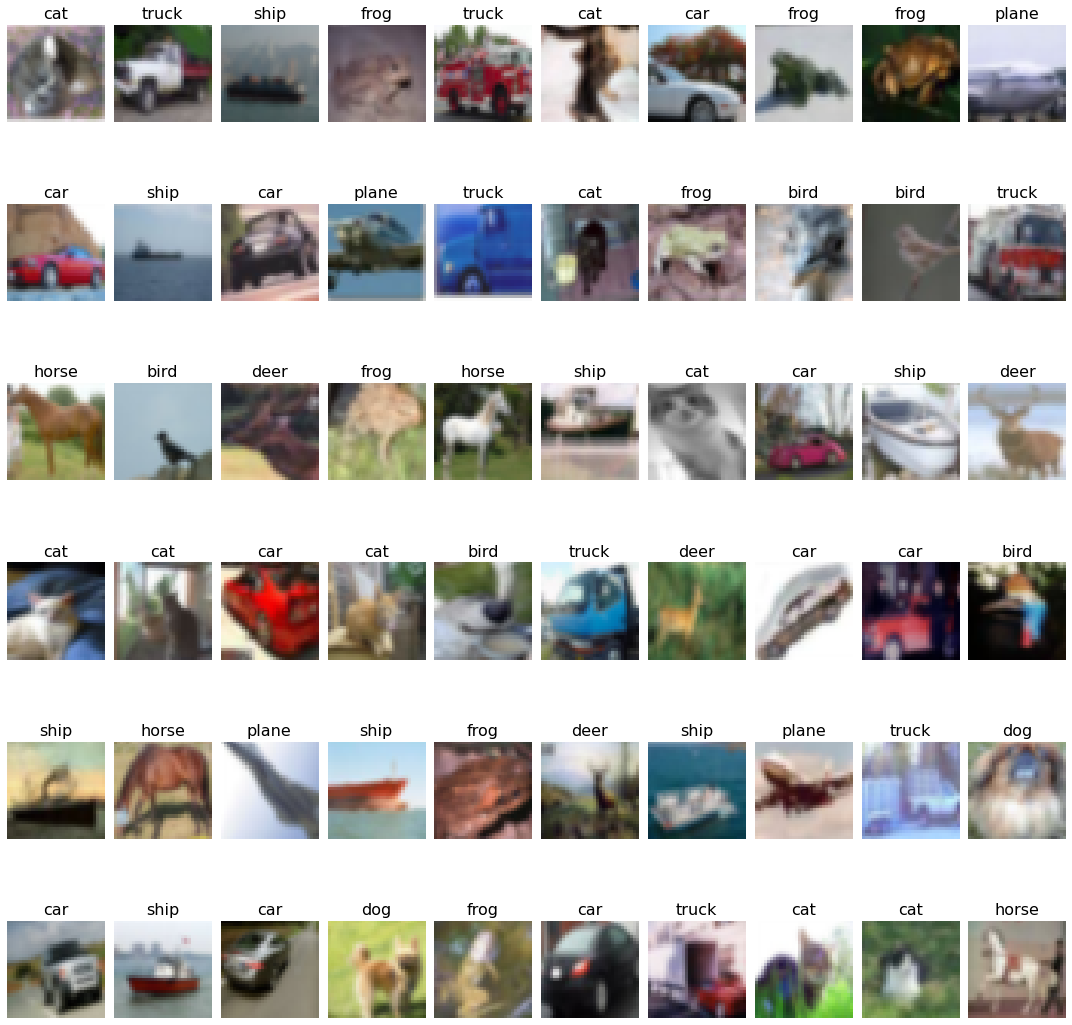

In [ ]:
# show trainset img
print("Some train set images:")
display(trainloader,[])

# ResNet

In [ ]:
# construct network
# output = (input - kernel_size + 2*padding)/stride + 1 向下取整
import torch.nn.functional as F
class ResBlock(nn.Module):
  def __init__(self, in_channel, out_channel, stride=1, downsample=None):
    super(ResBlock, self).__init__()
    self.main = nn.Sequential(
      nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=stride, padding=1, bias=False),
      nn.BatchNorm2d(out_channel),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=1, padding=1, bias=False),
      nn.BatchNorm2d(out_channel),
    )
    self.downsample = downsample

  def forward(self, x):
    short = x
    if self.downsample is not None:  # 对应于残差结构中的虚线，需要做一次下采样使得shape相同
      short = self.downsample(x)
    out = self.main(x)
    out += short
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, blocks_num, num_classes=10):
    super(ResNet, self).__init__()
    self.in_channel = 64
    self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=3, stride=1, padding=1, bias=False) # (32-3+2*1)/1+1=32, channel：3->64
    self.bn1 = nn.BatchNorm2d(self.in_channel)
    self.relu = nn.ReLU(inplace=True) # 32*32*64
    self.layer1 = self._make_layer(block, 64, blocks_num[0])
    self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
    self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
    self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512, num_classes)

  def _make_layer(self, block, channel, block_num, stride=1):
    downsample = None
    if stride != 1 or self.in_channel != channel: # 虚线残差结构
      downsample = nn.Sequential(
        nn.Conv2d(self.in_channel, channel, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(channel)
      )
    layers = []
    layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
    self.in_channel = channel
    for _ in range(1, block_num):
      layers.append(block(self.in_channel, channel)) # 实线残差结构 downsample:none
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

def resnet34():
  return ResNet(ResBlock, [3, 4, 6, 3])
def resnet18():
  return ResNet(ResBlock, [2, 2, 2, 2])

In [ ]:
device

device(type='cuda')

# Start Training

In [ ]:
# define model&optimizer
model = resnet18().to(device)
criterion = nn.CrossEntropyLoss() #交叉熵损失
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) # 随机梯度下降
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [ ]:
# training
def train(trainloader, model, device):
  train_loss = 0.0
  model.train()
  for i, (data,label) in enumerate(trainloader):
    inputs, labels = data.to(device), label.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*inputs.size(0)
  train_loss /= len(trainloader.sampler)
  return train_loss

In [ ]:
# validation
def validation(val_loader, model, device):
  val_loss = 0.0
  model.eval()
  for i, (data,label) in enumerate(val_loader):
    inputs, labels = data.to(device), label.to(device)
    with torch.no_grad():
      outputs = model(inputs)
      loss = criterion(outputs, labels)
    val_loss += loss.item()*inputs.size(0)
  val_loss /= len(val_loader.sampler)
  return val_loss

In [ ]:
# Start  train
loss_record = {'train': [], 'val': []}
for epoch in range(n_epoch):
  train_loss = train(trainloader, model, device)
  loss_record['train'].append(train_loss)
  val_loss = validation(val_loader, model, device)
  loss_record['val'].append(val_loss)
  print("Epoch:[{:3d}/{:3d}] TrainLoss:{:.5f} Val_Loss:{:.5f}".format(epoch+1,n_epoch,train_loss,val_loss))

print('Finished training after {} epochs'.format(n_epoch))
# save model
torch.save(model.state_dict(), PATH)
print("Save model!")

Epoch:[  1/100] TrainLoss:1.52896 Val_Loss:1.31336
Epoch:[  2/100] TrainLoss:1.04789 Val_Loss:1.25807
Epoch:[  3/100] TrainLoss:0.82291 Val_Loss:0.81680
Epoch:[  4/100] TrainLoss:0.69719 Val_Loss:0.82297
Epoch:[  5/100] TrainLoss:0.62531 Val_Loss:0.71458
Epoch:[  6/100] TrainLoss:0.56074 Val_Loss:0.57859
Epoch:[  7/100] TrainLoss:0.52322 Val_Loss:0.69641
Epoch:[  8/100] TrainLoss:0.48770 Val_Loss:0.57795
Epoch:[  9/100] TrainLoss:0.45562 Val_Loss:0.58772
Epoch:[ 10/100] TrainLoss:0.42747 Val_Loss:0.49306
Epoch:[ 11/100] TrainLoss:0.40284 Val_Loss:0.45404
Epoch:[ 12/100] TrainLoss:0.37851 Val_Loss:0.44942
Epoch:[ 13/100] TrainLoss:0.36087 Val_Loss:0.54958
Epoch:[ 14/100] TrainLoss:0.34493 Val_Loss:0.43563
Epoch:[ 15/100] TrainLoss:0.32930 Val_Loss:0.46730
Epoch:[ 16/100] TrainLoss:0.31114 Val_Loss:0.40762
Epoch:[ 17/100] TrainLoss:0.30181 Val_Loss:0.39442
Epoch:[ 18/100] TrainLoss:0.28258 Val_Loss:0.42416
Epoch:[ 19/100] TrainLoss:0.27161 Val_Loss:0.40306
Epoch:[ 20/100] TrainLoss:0.269

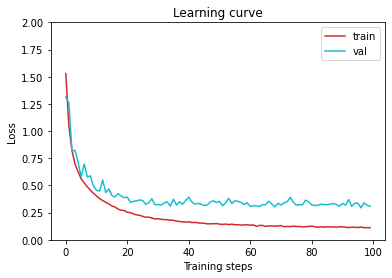

In [ ]:
#print(loss_record)
plot_learning_curve(loss_record)

# Testing

In [ ]:
# testing
def test(testloader, model, device):
  model.eval()
  correct_class = {classname: 0 for classname in classes}
  total_class = {classname: 0 for classname in classes} # {'plane':0,,,}
  pred = []
  gt = []
  correct = 0
  test_loss = 0.0
  for images,labels in testloader:
    # images = images.to(device)
    with torch.no_grad():
      outputs = model(images) # 128*10,一个batch中每张图像对应10种类别的概率
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs.data, dim=1) # max输出第一个为最大的值，第二个为最大值的索引
      pred.append(predicted)
      gt.append(labels)
      correct += (predicted == labels).sum().item() # 正确的个数
      for label, prediction in zip(labels, predicted):
        if label == prediction:
          correct_class[classes[label]] += 1
        total_class[classes[label]] += 1
    test_loss += loss.item()*images.size(0)
    print(test_loss)
  test_loss /= len(testloader.dataset)
  correct = correct / len(testloader.dataset) * 100
  pred = torch.cat(pred, dim=0).numpy()
  gt = torch.cat(gt, dim=0).numpy()
  return pred, gt, correct, test_loss, correct_class, total_class

In [ ]:
# load model
model = resnet18()
model.load_state_dict(torch.load(PATH)) 

<All keys matched successfully>

In [ ]:
preds, gt, correct, test_loss, correct_class, total_class = test(testloader, model, device)
print("Testing:\nTestLoss:{:.5f} Accurancy: {:.1f}%".format(test_loss, correct))
# cul the acc of all calss
for name, count in correct_class.items(): # [name: count]
  accuracy = 100*float(count)/total_class[name]
  print("Accuracy for class {:5s} is {:.1f}%".format(name,accuracy))

39.90250778198242
86.8075065612793
137.75454330444336
188.08485794067383
206.13449478149414
271.8768501281738
347.3044776916504
388.0796127319336
474.1570816040039
520.4951095581055
547.8077545166016
615.1815872192383
663.9799308776855
741.5483207702637
788.312744140625
850.0865440368652
912.4582023620605
978.8348197937012
1038.8778915405273
1100.9179229736328
1155.2610473632812
1222.0587539672852
1260.8183250427246
1329.638111114502
1394.6951484680176
1444.657772064209
1518.1501960754395
1561.7858772277832
1615.8907356262207
1691.0747032165527
1731.7967529296875
1787.3472213745117
1842.495231628418
1890.4756355285645
1932.7378959655762
2000.6352272033691
2051.3580932617188
2119.953125
2190.643943786621
2251.824867248535
2300.961280822754
2342.3957138061523
2398.6339225769043
2475.656032562256
2532.071517944336
2577.042190551758
2653.1982421875
2710.1874237060547
2766.8111000061035
2787.247802734375
2825.498203277588
2889.583484649658
2942.9319343566895
2985.812587738037
3046.380084991

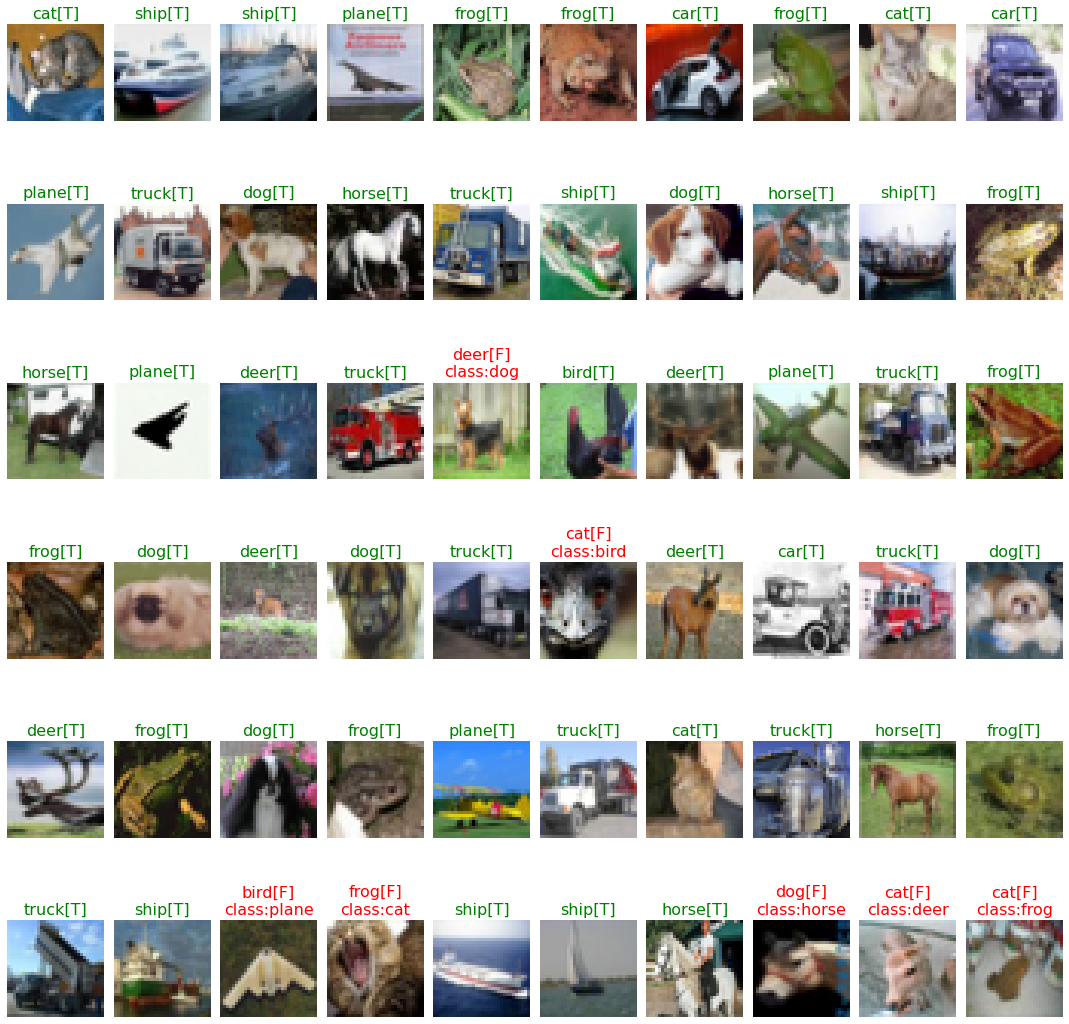

In [ ]:
display(testloader,torch.from_numpy(preds))

In [ ]:
# save csv
import csv
def save_pred(preds, gt, file):
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'ground-truth', 'prediction'])
        for i, p in enumerate(preds):
            writer.writerow([i, classes[gt[i]], classes[p]])

save_pred(preds, gt, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv
